In [1]:
###############
##Design the function "findRotMat" to  return 
# 1) rotMat1: a 2D numpy array which indicates the rotation matrix from xyz to XYZ 
# 2) rotMat2: a 2D numpy array which indicates the rotation matrix from XYZ to xyz 
###############

import numpy as np
import cv2

def findRotMat(alpha, beta, gamma):
    t1=np.pi*alpha/180
    t2=np.pi*beta/180
    t3=np.pi*gamma/180
    
    rotMat1=np.array([[np.cos(t1)*np.cos(t3)-np.sin(t1)*np.sin(t3)*np.cos(t2),-np.sin(t1)*np.cos(t3)-np.cos(t1)*np.cos(t2)*np.sin(t3),np.sin(t2)*np.sin(t3)],
                      [np.cos(t1)*np.sin(t3)+np.sin(t1)*np.cos(t2)*np.cos(t3),-np.sin(t1)*np.sin(t3)+np.cos(t1)*np.cos(t2)*np.cos(t3),-np.sin(t2)*np.cos(t3)],
                      [np.sin(t1)*np.sin(t2),np.cos(t1)*np.sin(t2),np.cos(t2)]])
    
    rotMat2=np.linalg.inv(rotMat1)
    
    return rotMat1,rotMat2


if __name__ == "__main__":
    alpha = 45
    beta = 30
    gamma = 50
    rotMat1, rotMat2 = findRotMat(alpha, beta, gamma)

In [2]:
###############
##Design the function "calibrate" to  return 
# (1) intrinsic_params: should be a list with four elements: [f_x, f_y, o_x, o_y], where f_x and f_y is focal length, o_x and o_y is offset;
# (2) is_constant: should be bool data type. False if the intrinsic parameters differed from world coordinates. 
#                                            True if the intrinsic parameters are invariable.
###############
import numpy as np
from cv2 import imread, cvtColor, COLOR_BGR2GRAY, TERM_CRITERIA_EPS, TERM_CRITERIA_MAX_ITER, \
    findChessboardCorners, cornerSubPix, drawChessboardCorners

def calibrate(imgname):
        
    #Setting the stop criteria for the corner search with accuracy of 0.001
    criteria = (TERM_CRITERIA_EPS + TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    objp = np.array([[4,0,4],[4,0,3],[4,0,2],[4,0,1],[3,0,4],[3,0,3],[3,0,2],[3,0,1],
                           [2,0,4],[2,0,3],[2,0,2],[2,0,1],[1,0,4],[1,0,3],[1,0,2],[1,0,1],
                           [0,1,4],[0,1,3],[0,1,2],[0,1,1],[0,2,4],[0,2,3],[0,2,2],[0,2,1],
                           [0,3,4],[0,3,3],[0,3,2],[0,3,1],[0,4,4],[0,4,3],[0,4,2],[0,4,1]],np.float32)
    
    #multiplying edge size to all points which is the distance b/n points
    objp *= 5 #5 mm is the size of an edge of check board
        
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    img=imread(imgname)
  
    gray=cvtColor(img,COLOR_BGR2GRAY)
    
    #find chessboard corners 
    found,corners=findChessboardCorners(gray,(4,9),None)
    found,corners=findChessboardCorners(gray,(4,9),None)
    
    if found==True:                
        #deleting the corners which are on the z axis to retain just 32 points
        corners  = np.delete(corners,tuple(range(16,20)),axis=0)
        corners2 = cornerSubPix(gray,corners,(4,4),(-1,-1),criteria)
        corners2 = cornerSubPix(gray,corners,(4,4),(-1,-1),criteria)
        
        imgpoints.append(corners2) #image points
        objpoints.append(objp)     #world points
        
        img = cv2.drawChessboardCorners(img, (4,4), corners2[0:15,:,:],found)
        img = cv2.drawChessboardCorners(img, (4,4), corners2[16:31,:,:],found)
        #cv2.namedWindow("output", cv2.WINDOW_NORMAL) 
        #cv2.imshow('output',img)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
    
    #Now we have 32 image points and world coordinates 
    #to find coefficients solution of the equation Mx=0 we have linear set of equations as matrix 
    #lets apply SVD- single decompostion to get the coefficients of projection matrix.
    
    worldpoints=objpoints[0]
    imagepoints=imgpoints[0]
    imagepoints = imagepoints.reshape((imagepoints.shape[0]*imagepoints.shape[1]), imagepoints.shape[2])
    
    wrow,wcol=worldpoints.shape
    irow,icol=imagepoints.shape
     
    n=wrow
    PM=np.zeros((2*n,12))
    
    for i in range(n):
        
        X,Y,Z=worldpoints[i]
        x,y=imagepoints[i]
        
        #Set of linear equations
        eqn1 = np.array([  X,  Y,  Z,  1,  0,  0,  0,  0, -(X*x), -(Y*x), -(Z*x), -(x)])
        eqn2 = np.array([  0,  0,  0,  0,  X,  Y,  Z,  1, -(X*y), -(Y*y), -(Z*y), -(y)])
        PM[2*i] = eqn1
        PM[(2*i) + 1] = eqn2
    
    U, S, VT = np.linalg.svd(PM)
    
    xroots=VT[-1]
    lambda1=np.sqrt(1/np.sum(xroots[8:11]**2))
    mmat=lambda1*xroots    
    mmat=mmat.reshape(3,4)
    
    ox=np.sum(np.multiply(mmat[0,0:3],mmat[2,0:3]))
    oy=np.sum(np.multiply(mmat[1,0:3],mmat[2,0:3]))
    
    fx=np.sqrt(np.sum(mmat[0,0:3]**2)-ox**2)
    fy=np.sqrt(np.sum(mmat[1,0:3]**2)-oy**2)
      
    intrmat=[fx,fy,ox,oy]
    
    return intrmat,True
    

if __name__ == "__main__":
    intrinsic_params, is_constant = calibrate('checkboard.png')

0.0003738660881405136


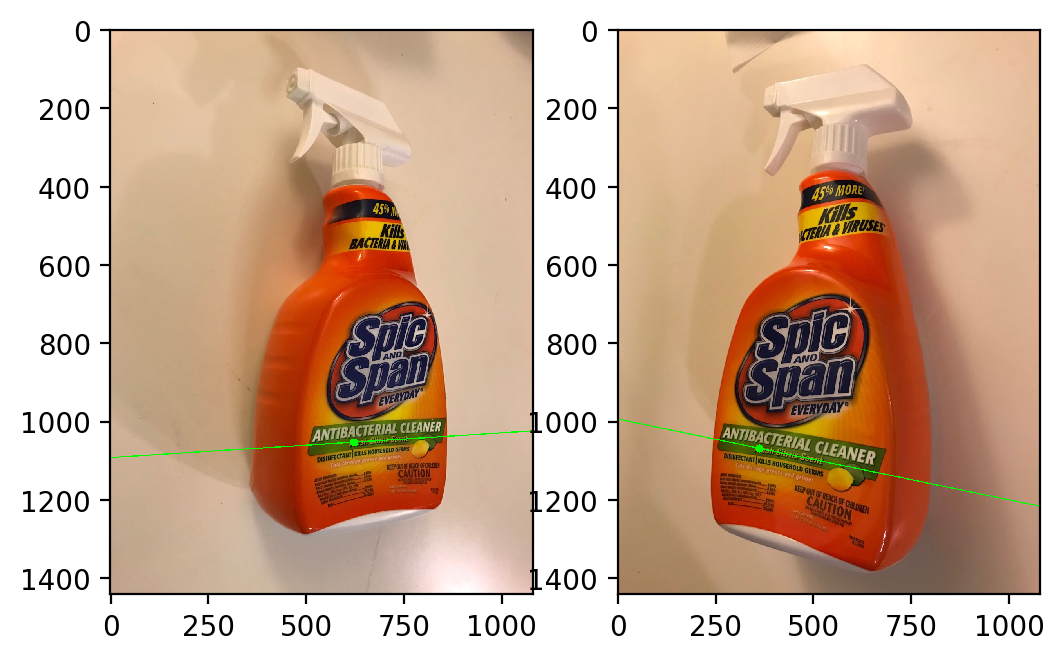

In [6]:
###############
##1. Design the function "rectify" to  return
# fundamentalMat: should be 3x3 numpy array to indicate fundamental matrix of two image coordinates. 
# Please check your fundamental matrix using "checkFunMat". The mean error should be less than 5e-4 to get full point.
##2. Design the function "draw_epilines" to  return
# draw1: should be numpy array of size [imgH, imgW, 3], drawing the specific point and the epipolar line of it on the left image; 
# draw2: should be numpy array of size [imgH, imgW, 3], drawing the specific point and the epipolar line of it on the right image.
# See the example of epilines on the PDF.
###############
from cv2 import imread, xfeatures2d, FlannBasedMatcher, cvtColor, COLOR_RGB2BGR, line, circle, computeCorrespondEpilines
import numpy as np
from matplotlib import pyplot as plt

def rectify(pts1, pts2):

    pts1=np.array(pts1)
    pts2=np.array(pts2)
        
    x=np.array(pts1[:,0])
    y=np.array(pts1[:,1])
    x1=np.array(pts2[:,0])
    y1=np.array(pts2[:,1])
    
    x=x.reshape(x.shape[0],1)
    y=y.reshape(y.shape[0],1)
    x1=x1.reshape(x1.shape[0],1)
    y1=y1.reshape(y1.shape[0],1)
    
    n=x.shape[0]
    M=np.empty((n,9))
    
    #Eight point algorithm - Linear combination of equations to calculate fundamental matrix AF=0
    for i in range(n):
        M[i]=np.array([x1[i]*x[i], x1[i]*y[i], x1[i], y1[i]*x[i], y1[i]*y[i], y1[i], x[i], y[i], 1])
    
    #AF=0 solve for F using SVD
    U, S, VT = np.linalg.svd(M)

    funmat=VT[-1]
    funmat=funmat.reshape(3,3).T
    
    return funmat

def draw_epilines(img1, img2, pt1, pt2, fmat):
    
    img1 = cvtColor(img1,COLOR_RGB2BGR)
    img2 = cvtColor(img2,COLOR_RGB2BGR)
    color=(0,255,0)
    
    #Find and mark the points and epilines on left image- Triangularization
    ll=computeCorrespondEpilines(np.array([list(pt2)]),1,fmat)
    ll = ll.reshape(3)
    lr, lc, ld = img1.shape 
    x, y = map(int, [0, -ll[2] / ll[1]]) 
    x1,y1 = map(int,[lc, -(ll[2] + ll[0] * lc) / ll[1]]) 
    img1 = line(img1,(x, y), (x1, y1), color, 2) 
    img1 = circle(img1,tuple(np.float32(pt1)), 10, color, -1) 
    
    
    #Find and mark the points and epilines on right image- Triangularization
    rl=computeCorrespondEpilines(np.array([list(pt1)]),2,fmat)
    rl=rl.reshape(3)
    rr, rc, rd = img2.shape 
    x, y = map(int, [0, -rl[2] / rl[1]]) 
    x1,y1 = map(int,[rc, -(rl[2] + rl[0] * rc) / rl[1]]) 
    img2 = line(img2,(x, y), (x1, y1), color, 2) 
    img2 = circle(img2,tuple(np.float32(pt2)), 10, color, -1) 

    return img1,img2

def checkFunMat(pts1, pts2, fundMat):
    N = len(pts1)
    assert len(pts1)==len(pts2)
    errors = []
    for n in range(N):
        v1 = np.array([[pts1[n][0], pts1[n][1], 1]])#size(1,3)
        v2 = np.array([[pts2[n][0]], [pts2[n][1]], [1]])#size(3,1)
        error = np.abs((v1@fundMat@v2)[0][0])
        errors.append(error)
    error = sum(errors)/len(errors)
    return error
    
if __name__ == "__main__":
    img1 = imread('rect_left.jpeg') 
    img2 = imread('rect_right.jpeg')

    # find the keypoints and descriptors with SIFT
    sift = xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters for points match
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    pts1 = []
    pts2 = []
    dis_ratio = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.3*n.distance:
            good.append(m)
            dis_ratio.append(m.distance/n.distance)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    min_idx = np.argmin(dis_ratio) 
    
    # calculate fundamental matrix and check error
    fundMat = rectify(pts1, pts2)
    error = checkFunMat(pts1, pts2, fundMat)
    print(error)
    
    # draw epipolar lines
    draw1, draw2 = draw_epilines(img1, img2, pts1[min_idx], pts2[min_idx], fundMat)
    
    # save images
    fig, ax = plt.subplots(1,2,dpi=200)
    ax=ax.flat
    ax[0].imshow(draw1)
    ax[1].imshow(draw2)
    fig.savefig('rect.png')

In [4]:
#Task1
p1=np.array([[-0.71276632],
 [-0.32498039],
 [ 3.65873638]])

alpha = 45
beta = 30
gamma = 50
rotMat1, rotMat2 = findRotMat(alpha, beta, gamma)

p=rotMat1 @ p1
print(p)

p1=rotMat2 @ p
print(p1)

[[ 1.71193273]
 [-1.79443271]
 [ 2.80165978]]
[[-0.71276632]
 [-0.32498039]
 [ 3.65873638]]


In [5]:
#task2
intrinsic_params, is_constant = calibrate('checkboard.png')
print(intrinsic_params)
print(is_constant)

[2784.9249756132326, 2784.887357033184, 996.5020723329208, 562.9259025182622]
True
